## Display webcam within notebook
I wrote these helper functions to display the webcam feed from OpenCV directly within the Jupyter notebook. Some code has been adapted from [here](https://github.com/NicksonYap/Jupyter-Webcam).

The first function `notebook_display_init` will display a new image in the output of the cell. It will return an ID which is passed to `notebook_display_update` to update that image with a new one subsequently.

In [1]:
from io import BytesIO
import IPython.display
import PIL
import PIL.Image

# Use 'jpeg' instead of 'png' (~5 times faster)

def notebook_display_init(a, fmt='jpeg', _id=True):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    obj = IPython.display.Image(data=f.getvalue())
    return IPython.display.display(obj, display_id=_id)

def notebook_display_update(a, fmt='jpeg', display_id=None):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    obj = IPython.display.Image(data=f.getvalue())
    if display_id:
        display_id.update(obj)
    else:
        IPython.display.clear_output(wait=True)
        return IPython.display.display(obj, display_id=True)


Disable scrolling in IPython output for the whole image to show up nicely

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Application Dashboard
This cell of code will retrieve the detected people and display a dashboard of the seat location and the number of vacancies.

Ensure that the other notebook for the main webcam loop is running simultaneously.

IntProgress(value=0, bar_style='info', description='Vacant Seats', layout=Layout(height='100px', width='100%')…

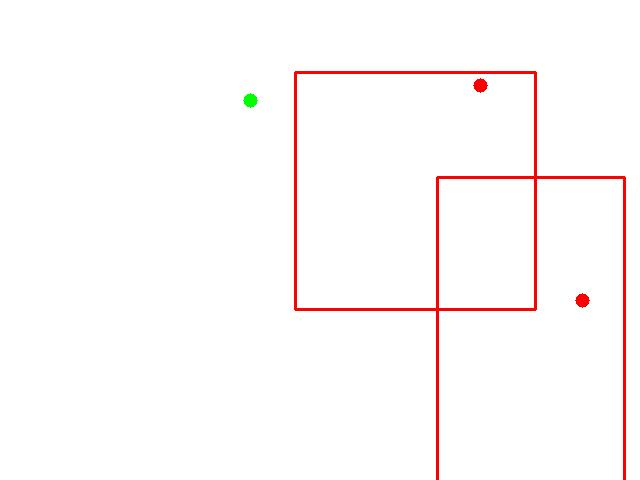

KeyboardInterrupt: 

In [3]:
import time
import numpy as np
import cv2
import ipywidgets as widgets
from ipywidgets import IntProgress, Layout

# Setup progressbar
progressbar = IntProgress(min=0, max=100,
                          description="Vacant Seats",
                         layout=Layout(width='100%', height='100px'))
progressbar.bar_style = 'info'
IPython.display.display(progressbar)
    
test_image = 255 * np.ones(shape=[1, 1, 3], dtype=np.uint8)
nb_display = notebook_display_init(test_image)
statistics_out = widgets.Output()

points = [
    (250, 100), # left seat
    (480, 85), # top seat
    (582, 300), # right seat
]
taken_points = [0] * len(points)

UPDATE_RATE = 0.25  # in seconds
HOLD_TIME = 3 # seconds to hold availability
while True:
    time.sleep(0.25)
    
    # Retrieve the YoloV3 outputs from the IPython database
    %store -r boxes
    %store -r classes
    %store -r class_names
    %store -r image_size
    
    # Create empty white image
    img_x, img_y = image_size
    image = 255 * np.ones(shape=[img_x, img_y, 3], dtype=np.uint8)
    
    # Process each box and determine availability of points
    for i, bbox in enumerate(boxes):
        try:
            class_index = classes[i]
            class_name = class_names[class_index]
            if class_name not in ['person']:
                continue

            # [top, left, bottom, right] = bbox
            y1, x1, y2, x2 = bbox

            # check availability
            for j, p in enumerate(points):
                x, y = p
                taken = (x1 < x < x2) and (y1 < y < y2)
                if taken:
                    taken_points[j] = int(HOLD_TIME / 0.25)

            # Draw rectangle
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        except:
            break
        
    for i, taken_point in enumerate(taken_points):
        # Draw points and deduct taken_point
        center_point = points[i]
        if taken_point > 0:
            circle_color = (255, 0, 0)
            taken_points[i] -= 1
        else:
            circle_color = (0, 255, 0)
        
        cv2.circle(image, center_point, 1, circle_color, thickness=12, lineType=8, shift=0)

    # display image
    notebook_display_update(image, display_id=nb_display)
    
    # update progressbar
    progressbar.value = 100 - int(sum(map(lambda p: p > 0, taken_points)) / len(points) * 100)
    
    with statistics_out:
        statistics_out.clear_output()
        print(image_size)
       